**Loading Dataset**

In [1]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [2]:
import requests
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten

def extract_features(url):
    # Initialize the feature dictionary
    features = {}

    # Extract URL features
    features['URL'] = url
    parsed_url = urlparse(url)
    features['Domain'] = parsed_url.netloc
    features['TLD'] = parsed_url.netloc.split('.')[-1]
    features['URLLength'] = len(url)

    # Fetch webpage content
    try:
        response = requests.get(url)
        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')
    except:
        # If unable to fetch webpage content, return None for all features
        for feature in categorical_features + numerical_features:
            features[feature] = None
        return features

    # Extract Title
    title = soup.title
    features['Title'] = title.string if title else None

    # Extract numerical features

    # Domain length
    features['DomainLength'] = len(features['Domain'])

    # IsDomainIP
    features['IsDomainIP'] = 1 if re.match(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$', features['Domain']) else 0

    # TLD length
    features['TLDLength'] = len(features['TLD'])
    # Number of subdomains
    features['NoOfSubDomain'] = len(parsed_url.netloc.split('.')) - 2  # Subtract 2 for domain and TLD

    # Other numerical features (placeholders)
    features['HasObfuscation'] = any(x in url for x in ['%', '//', '@'])  # Simple heuristic for obfuscation
    features['NoOfLettersInURL'] = sum(c.isalpha() for c in url)
    features['LetterRatioInURL'] = features['NoOfLettersInURL'] / len(url)
    features['NoOfDegitsInURL'] = sum(c.isdigit() for c in url)
    features['DegitRatioInURL'] = features['NoOfDegitsInURL'] / len(url)
    features['NoOfEqualsInURL'] = url.count('=')
    features['NoOfQMarkInURL'] = url.count('?')
    features['NoOfAmpersandInURL'] = url.count('&')
    features['NoOfOtherSpecialCharsInURL'] = sum(not c.isalnum() for c in url) - features['NoOfEqualsInURL'] - features['NoOfQMarkInURL'] - features['NoOfAmpersandInURL']
    features['SpacialCharRatioInURL'] = features['NoOfOtherSpecialCharsInURL'] / len(url)
    features['IsHTTPS'] = 1 if parsed_url.scheme == 'https' else 0

    # Feature: Line of Code
    features['LineOfCode'] = len(html_content.splitlines())
    # Feature: Largest Line Length
    features['LargestLineLength'] = max(len(line) for line in html_content.splitlines())
    features['HasFavicon'] = bool(soup.find("link", rel="shortcut icon"))
    # Feature: Bank, Pay, Crypto (simple keywords in text)
    text = soup.get_text().lower()
    features['Bank'] = 'bank' in text
    features['Pay'] = 'pay' in text
    features['Crypto'] = 'crypto' in text
    features['NoOfImage'] = len(soup.find_all('img'))
    features['NoOfCSS'] = len(soup.find_all('link', {'rel': 'stylesheet'}))
    features['NoOfJS'] = len(soup.find_all('script', {'src': True}))
    features['NoOfSelfRef'] = len(soup.find_all(href=re.compile(url)))
    # Feature: Number of Empty References
    features['NoOfEmptyRef'] = len([a for a in soup.find_all('a', href=True) if a['href'] in ['', '#', 'javascript:void(0);']])
    domain = urlparse(url).netloc
    features['NoOfExternalRef'] = len([a for a in soup.find_all('a', href=True) if urlparse(a['href']).netloc and urlparse(a['href']).netloc != domain])


    # Return the extracted features
    return features




# Fetch dataset
phishing_url_website = fetch_ucirepo(id=967)

# Display metadata
print(phishing_url_website.metadata)

# Display variable information
print(phishing_url_website.variables)

# Convert features and targets into pandas DataFrame
X_df = pd.DataFrame(phishing_url_website.data.features[:10000], columns=phishing_url_website.feature_names)
y_df = pd.DataFrame(phishing_url_website.data.targets[:10000], columns=['label'])

# Selecting categorical and numerical features
categorical_features = ['URL', 'Domain', 'TLD', 'Title']
numerical_features = [
    'URLLength', 'DomainLength', 'IsDomainIP', 'TLDLength', 'NoOfSubDomain',
    'HasObfuscation', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL',
    'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
    'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode',
    'LargestLineLength', 'Bank', 'Pay', 'Crypto', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
    'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'HasFavicon'
]









{'uci_id': 967, 'name': 'PhiUSIIL Phishing URL (Website)', 'repository_url': 'https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/967/data.csv', 'abstract': 'PhiUSIIL Phishing URL Dataset is a substantial dataset comprising 134,850 legitimate and 100,945 phishing URLs. Most of the URLs we analyzed, while constructing the dataset, are the latest URLs. Features are extracted from the source code of the webpage and URL. Features such as CharContinuationRate, URLTitleMatchScore, URLCharProb, and TLDLegitimateProb are derived from existing features.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 235795, 'num_features': 54, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['label'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2024, 'last_updated': 'Mon Mar 18 

**Normalizing Dataset**

In [3]:
# Encoding categorical data
encoder = OneHotEncoder()
X_categorical = X_df[categorical_features]
X_categorical_encoded = encoder.fit_transform(X_categorical)

# Normalizing numerical data
scaler = StandardScaler()
X_numerical = X_df[numerical_features]
X_numerical_normalized = scaler.fit_transform(X_numerical)

# Combine encoded categorical data and normalized numerical data
X_processed = np.concatenate((X_categorical_encoded.toarray(), X_numerical_normalized), axis=1)

# Splitting data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_processed, y_df, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)



**Building Model**

Epoch 1/3
94/94 [==============================] - 40s 351ms/step - loss: 0.3366 - accuracy: 0.8695 - val_loss: 0.0892 - val_accuracy: 0.9760
Epoch 2/3
94/94 [==============================] - 31s 329ms/step - loss: 0.0628 - accuracy: 0.9838 - val_loss: 0.0344 - val_accuracy: 0.9870
Epoch 3/3
94/94 [==============================] - 31s 329ms/step - loss: 0.0283 - accuracy: 0.9925 - val_loss: 0.0152 - val_accuracy: 0.9935


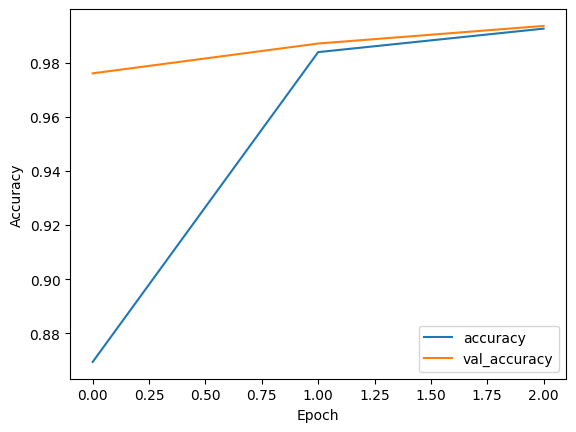

In [4]:
# Reshape data for Conv1D layer
X_train_conv = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_conv = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Build the model
model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_conv.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(50))

# Dense layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_conv, y_train, epochs=10, batch_size=64, validation_data=(X_val_conv, y_val), verbose=1)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Evaluation on validation dataset**

63/63 [==============================] - 8s 110ms/step


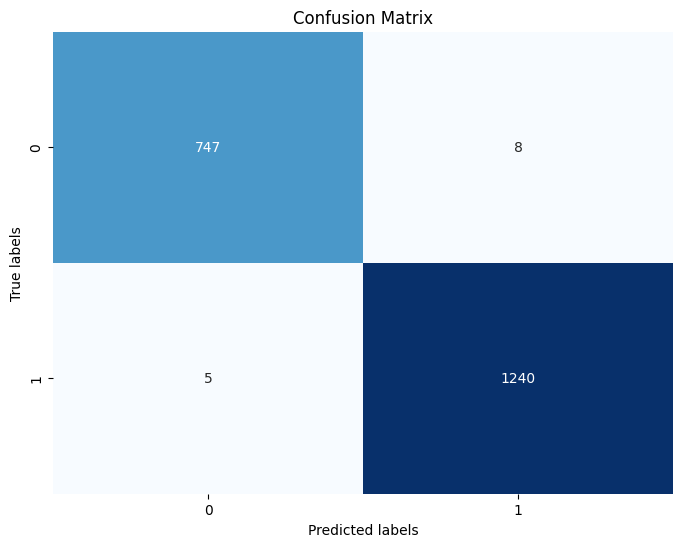

63/63 [==============================] - 6s 100ms/step
Test Metrics:
Accuracy: 0.994
F1 Score: 0.9950413223140496
Recall: 0.9950413223140496


In [5]:
# Evaluate on validation set
y_pred_proba = model.predict(X_val_conv)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the model's performance on the test set
X_test_conv = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test_pred = (model.predict(X_test_conv) > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("Test Metrics:")
print("Accuracy:", test_accuracy)
print("F1 Score:", test_f1)
print("Recall:", test_recall)

**Testing on websites**

In [8]:
# Define a function to preprocess and evaluate a URL
def evaluate_website(url, model):
    # Extract features
    features = extract_features(url)

    # Convert features to DataFrame
    features_df = pd.DataFrame([features])

    # Define the list of categorical and numerical features for website evaluation
    categorical_features_eval = ['URL', 'Domain', 'TLD', 'Title']
    numerical_features_eval = [
    'URLLength', 'DomainLength', 'IsDomainIP', 'TLDLength', 'NoOfSubDomain',
    'HasObfuscation', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL',
    'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
    'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode',
    'LargestLineLength', 'Bank', 'Pay', 'Crypto', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
    'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'HasFavicon'
]

    # Initialize encoded categorical features with zeros
    X_categorical_encoded = np.zeros((features_df.shape[0], len(encoder.categories_)), dtype=int)

    # Encode categorical data if present
    for i, feature in enumerate(categorical_features_eval):
        if feature in encoder.get_feature_names_out():
            feature_index = list(encoder.get_feature_names_out()).index(feature)
            category = features_df[feature].iloc[0]
            if category in encoder.categories_[i]:
                category_index = list(encoder.categories_[i]).index(category)
                X_categorical_encoded[0, feature_index + category_index] = 1

    # Normalize numerical data
    X_numerical = features_df[numerical_features_eval]
    X_numerical_normalized = scaler.transform(X_numerical)

    # Combine encoded categorical data and normalized numerical data
    X_processed = np.concatenate((X_categorical_encoded, X_numerical_normalized), axis=1)

    # Reshape data for Conv1D layer
    X_processed_conv = X_processed.reshape((X_processed.shape[0], X_processed.shape[1], 1))

    # Predict using the model
    prediction_proba = model.predict(X_processed_conv)
    prediction = (prediction_proba > 0.5).astype(int)

    # Return the prediction
    return prediction[0][0], prediction_proba[0][0]
    # Extract features
    features = extract_features(url)

    # Convert features to DataFrame
    features_df = pd.DataFrame([features])

    # Initialize encoded categorical features with zeros
    X_categorical_encoded = np.zeros((features_df.shape[0], len(encoder.categories_)), dtype=int)

    # Encode categorical data if present
    for i, feature in enumerate(categorical_features_eval):
        if feature in encoder.get_feature_names_out():
            feature_index = list(encoder.get_feature_names_out()).index(feature)
            category = features_df[feature].iloc[0]
            if category in encoder.categories_[i]:
                category_index = list(encoder.categories_[i]).index(category)
                X_categorical_encoded[0, feature_index + category_index] = 1

    # Normalize numerical data
    X_numerical = features_df[numerical_features_eval]
    X_numerical_normalized = scaler.transform(X_numerical)

    # Combine encoded categorical data and normalized numerical data
    X_processed = np.concatenate((X_categorical_encoded, X_numerical_normalized), axis=1)

    # Reshape data for Conv1D layer
    X_processed_conv = X_processed.reshape((X_processed.shape[0], X_processed.shape[1], 1))

    # Predict using the model
    prediction_proba = model.predict(X_processed_conv)
    prediction = (prediction_proba > 0.5).astype(int)

    # Return the prediction
    return prediction[0][0], prediction_proba[0][0]

# Example usage:
websites = ["https://www.uni-mainz.de", "https://www.journalofwoundcare.com","https://caniphish.com/free-phishing-test/phishing-website-templates#signupForm", "https://thekickasstorrents.com/"]

for website in websites:
    prediction, confidence = evaluate_website(website, model)
    print("Website:", website)
    print("Prediction:", "Phishing" if prediction == 1 else "Legitimate")
    print("Confidence:", confidence)
    print()

1/1 [==============================] - 0s 26ms/step
Website: https://www.uni-mainz.de
Prediction: Phishing
Confidence: 0.8114302

1/1 [==============================] - 0s 19ms/step
Website: https://www.journalofwoundcare.com
Prediction: Legitimate
Confidence: 0.0010995688

1/1 [==============================] - 0s 18ms/step
Website: https://caniphish.com/free-phishing-test/phishing-website-templates#signupForm
Prediction: Legitimate
Confidence: 0.024485167

1/1 [==============================] - 0s 20ms/step
Website: https://thekickasstorrents.com/
Prediction: Legitimate
Confidence: 0.00034976623

